In [1]:
import os
import numpy as np
import dask
#from dask_jobqueue import PBSCluster
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
dmethod = 1
#
if dmethod == 1:
    from dask.distributed import Client
    scheduler = os.getenv('DATAWORK')+'/dask/scheduler.json'
    client = Client(scheduler_file=scheduler)
elif dmethod == 2:
    from dask_jobqueue import PBSCluster
    # folder where data is spilled when RAM is filled up
    local_dir = os.getenv('TMPDIR')
    #
    cluster = PBSCluster(queue='mpi_1', local_directory=local_dir, interface='ib0', walltime='24:00:00',
                         threads=14, processes=2, memory='50GB', resource_spec='select=1:ncpus=28:mem=100g', 
                         death_timeout=100)
    w = cluster.start_workers(40)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# you need to wait for workers to spin up
if dmethod == 2:
    cluster.scheduler

In [4]:
# get dask handles and check dask server status
if dmethod == 2:
    from dask.distributed import Client
    client = Client(cluster)

In [5]:
client

Client Scheduler: tcp://10.148.1.36:8786 Dashboard: http://10.148.1.36:8787/status,Cluster Workers: 20 Cores: 280 Memory: 2000.00 GB


---

# automatic extraction of all variables

In [6]:
data_rdir = '/home/datawork-lops-osi/data/mit4320/'
grid_dir = data_rdir+'grid/'
out_dir = '/home1/datawork/xyu/iwsst_mit/'

def extract(v, t, face, i, j, pref=''):
    
    data_dir = data_rdir+v+'/'

    iters, time = get_iters_time(v, data_dir, delta_t=25.)
    
    p = 'C'
    if v is 'SSU':
        p = 'W'
    elif v is 'SSV':
        p = 'S'
    ds = get_compressed_data(v, data_dir, grid_dir, iters=iters, time=time, client=client, point=p)
    ds = ds.chunk({'face': 1})
    #print(ds)

    file_out = out_dir+pref+v+'.nc'
    ds[v].isel(time=t, face=face, i=i, j=j).to_netcdf(file_out, mode='w', unlimited_dims='time')
    

In [7]:
V = ['Eta', 'SST', 'SSU', 'SSV']
#V = ['Eta', 'SST']
#V = ['SSU']
#V = ['SST']

ext = {}
#ext['mad'] = {'time': slice(0,24), 'face': 1, 'i': slice(3000,None), 'j': slice(1000,4000)}
ext['nwa'] = {'time': slice(0,24), 'face': 4, 'i': slice(2000,4000), 'j': slice(1500,3500)}
#ext['mad'] = {'time': slice(0,1000), 'face': 1, 'i': slice(1000,2000), 'j': slice(1000,2000)}
for key, e in ext.items():
    print('face = %d' %e['face'])
    for v in V:
        print(v)
        extract(v, e['time'], e['face'], e['i'], e['j'], pref=key+'_')
        
        

face = 4
Eta


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/mds_store.py:721: UserWarning: Couldn't find available_diagnostics.log in . Using default version.
  "in %s. Using default version." % data_dir)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/worker.py:742: UserWarning: Large object of size 5.62 MB detected in task graph: 
  ("('astype-716106550b6c50e8ad94afb212ec7431', 

SST
SSU
SSV


---

# manual exploration in order to get index slices

In [8]:
data_dir = data_rdir+'Eta/'

iters, time = get_iters_time('Eta', data_dir, delta_t=25.)

ds = get_compressed_data('Eta', data_dir, grid_dir, iters=iters, time=time, client=client)
#ds = ds.chunk({'face': 1})
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/mds_store.py:721: UserWarning: Couldn't find available_diagnostics.log in . Using default version.
  "in %s. Using default version." % data_dir)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90, time: 4096)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC       (face, j, i) >f4 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    YC       (face, j, i) >f4 dask.array<shape=(13, 4320, 4320), chunksize=(

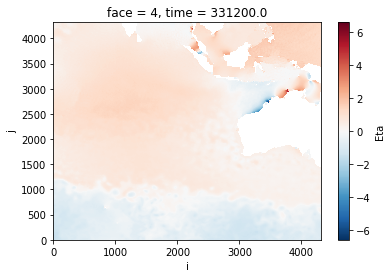

In [10]:
ds['Eta'].isel(time=20, face=4).plot()

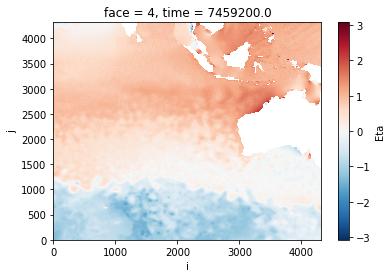

In [11]:
ds['Eta'].isel(time=2000, face=4).plot()

In [ ]:
ds['Eta'].isel(face=4, i=0, j=0).mean().compute()

In [ ]:
ds['SST'].isel(face=4, i=2000, j=2000).plot()

## produce a netcdf file

In [21]:
ds.isel(time=slice(0,24), face=4)

<xarray.Dataset>
Dimensions:  (i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90, time: 24)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    face     int64 4
    XC       (j, i) >f4 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
    YC       (j, i) >f4 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
    XG       (j_g, i_g) >f4 dask.array<shape=(4320, 4320

In [22]:
file_out = os.getenv('DATAWORK')+'/sst_extract.nc'
#ds.isel(time=slice(0,24), face=1).to_netcdf(file_out, mode='w', unlimited_dims='time') # not working, weird incompatible chunk error
ds['SST'].isel(time=slice(0,24), face=4, i=slice(0,4320), j=slice(0,4320)).to_netcdf(file_out, mode='w', unlimited_dims='time')

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/client.py", line 1353, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/client.py", line 1353, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  

In [15]:
print(file_out)

/home1/datawork/xyu/ssh_extract.nc


---

# try to transpose data

In [14]:
#eta = ds['Eta'].isel(time=slice(0,24), face=1)
#print('\n data size: %.1f GB' %(eta.nbytes / 1e9))
#eta = ds['Eta'].transpose() # not lazy: 



 data size: 1.8 GB
